# Code Reproducibility Example

## Imports

In [2]:
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import pandas as pd
from cv2 import *
from PIL import Image
import time
import os
import pandas as pd
import torch
#import torchvision
import torch.nn as nn
import torch.nn.functional as F

## EgoGesture Loaders

In [3]:
def load_image_data(movie_path, frame_indices, headless=False, background_subtract=False, randomize=False):
    frame = None
    start_frame, end_frame = frame_indices
    mid_frame = (start_frame + end_frame) // 2
    cap = cv2.VideoCapture(movie_path)
    i = 1
    while(cap.isOpened()):
        ret, frame = cap.read()
        i += 1
        if i == mid_frame:
            if randomize:
                pass
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            if background_subtract:
                frame = cv2.subtract(frame, background)
                
            if not headless:
                cv2.imshow('Frame', frame)
                time.sleep(0.05)
            
            break
            
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    return frame, i

In [4]:
def load_video_data(movie_path, frame_indices, image=False, headless=False, background_subtract=False, randomize=False):
    data = []
    start_frame, end_frame = frame_indices
    cap = cv2.VideoCapture(movie_path)
    i = 1
    while(cap.isOpened()):
        ret, frame = cap.read()
        i += 1
        if start_frame < i < end_frame:
            if randomize:
                pass
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            if background_subtract:
                frame = cv2.subtract(frame, background)
                
            if not headless:
                cv2.imshow('Frame', frame)
                time.sleep(0.05)
            
            data.append(frame)

        if i > end_frame or cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    
    data = np.array(data)
    
    if image:
        return np.mean(data, axis=0), i
    return data, i

In [5]:
def show_data(data, verbose=False):    
    fig, axs = plt.subplots(2, 5, figsize=(15, 15))
    indices = iter(np.linspace(0, len(data)-1, 10))

    for i in range(2):
        for j in range(5):
            index = int(next(indices))
            frame = data[index]
            axs[i][j].xaxis.set_visible(False)
            axs[i][j].yaxis.set_visible(False)
            axs[i][j].imshow(frame)

In [8]:
def load_sample(subject, scene, gesture, image=False, headless=False):    
    # Get labels' path    
    subject_path_for_labels = 'subject0{}'.format(subject) if (subject < 10) else 'subject{}'.format(subject)
    scene_path_for_labels = 'Scene{}'.format(scene)
    labels_path = 'data/{}/{}'.format(subject_path_for_labels, scene_path_for_labels)
    
    # Change directory to current directory.
    cwd = os.getcwd()
    os.chdir(labels_path)
    groups = os.listdir(os.getcwd())
    
    # Iterate through all gesture-frame pairs
    for group_csv, group_num in zip(groups, range(1, len(groups) + 1)):
        frames = pd.read_csv(group_csv, header=None)
        if gesture in frames[0].values:
            os.chdir(cwd)
            frame_indices = frames[frames[0] == gesture].values[0][1:]
            
            # Get video path
            subject_path_for_videos = 'Subject0{}'.format(subject) if subject < 10 else 'Subject{}'.format(subject)
            scene_path_for_videos = 'Scene{}'.format(scene)
            video_path = 'Videos/{}/{}/Color/rgb{}.avi'.format(subject_path_for_videos, scene_path_for_videos, group_num)
        
            # Load gesture data
            data = load_video_data(video_path, frame_indices, image, headless)
            return data
        
    os.chdir(cwd)    
    return None

## Classification Example

In [9]:
def load_data(gesture, num_subjects):
    return [load_sample(subject, 1, gesture, image=False, headless=False) for subject in range(1, num_subjects)]

data_43 = load_data(43, 35)
data_62 = load_data(62, 35)

FileNotFoundError: [Errno 2] No such file or directory: 'data/subject36/Scene1'

In [ ]:
def truncate(clip):
    num_frames = clip[0].shape[0]
    start = num_frames // 2
    end = start + num_frames // 4
    truncated = clip[0][start:end]
    return truncated
    
frames_43 = [truncate(clip) for clip in data_43]
frames_62 = [truncate(clip) for clip in data_62]

In [ ]:
all_43 = np.array([image.flatten() for image in np.concatenate((frames_43))]);
all_62 = np.array([image.flatten() for image in np.concatenate((frames_62))]);

all_43.shape, all_62.shape

In [ ]:
labels = np.array([0 for _ in range(476)] + [1 for _ in range(378)])

In [ ]:
all_data = np.concatenate((all_43, all_62))

In [ ]:
from sklearn import svm, metrics
classifier = svm.SVC(gamma=0.001)

In [ ]:
classifier.fit(all_data, labels) 

In [ ]:
classifier.score(all_data, labels)

# Baseline Evaluation Models

## PyTorch CNN

In [146]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.enc1 = nn.Linear(in_features=307200, out_features=153600)
        self.enc2 = nn.Linear(in_features=153600, out_features=76800)
        self.enc3 = nn.Linear(in_features=76800, out_features=2)
        
        # Decoder 
        self.dec1 = nn.Linear(in_features=2, out_features=76800)
        self.dec2 = nn.Linear(in_features=76800, out_features=153600)
        self.dec3 = nn.Linear(in_features=153600, out_features=307200)
    
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x
    
net = Autoencoder()
print(net)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:75] data. DefaultCPUAllocator: not enough memory: you tried to allocate 188743680000 bytes. Buy new RAM!

In [18]:
def star_clip(clip, euclidean=False):
    
    N = len(clip)
    M = np.zeros(clip[0].shape)
    for k in range(2, N):
        w_s = k/N
        I_k_1 = clip[k-1]
        I_k = clip[k]
        if euclidean:
            frame_diff = (I_k_1 - I_k) 
        frame_diff = I_k_1 - I_k
        delta = np.abs(frame_diff) * w_s
        M += delta
    
    M_x = cv2.Sobel(M, cv2.CV_64F, 1, 0, ksize=5)
    M_y = cv2.Sobel(M, cv2.CV_64F, 0, 1, ksize=5)
    star = np.array([M, M_x, M_y])
    
    return star

In [20]:
star_43 = [(star_clip(sample[0]), sample[1]) for sample in data_43]
star_62 = [(star_clip(sample[0]), sample[1]) for sample in data_62]

star_samples = star_43 + star_62
np.random.shuffle(star_samples)

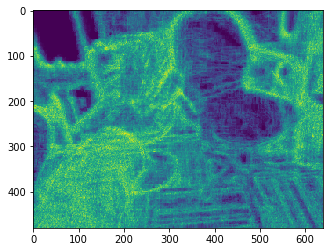

In [36]:
plt.imshow(star_43[22][0][0]);

In [ ]:
def prepare_batches(data, batch_size, shuffle=False):    
    batches, labels = [], []
    i = 0
    while i < len(star_samples):
        batches.append(torch.tensor([sample[0] for sample in star_samples[i:i+4]]).float())
        labels.append(torch.tensor([sample[1] for sample in star_samples[i:i+4]]).long())
        i += batch_size
    return batches, labels

In [11]:
data, labels = prepare_batches(star_samples, 4)

In [28]:
def show_video_data(frames, background_subtract=False, randomize=False):
    cap = cv2.VideoCapture(frames)
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if background_subtract:
            frame = cv2.subtract(frame, background)
            
        cv2.imshow('Frame', frame)
        time.sleep(0.05)
            

    cap.release()
    cv2.destroyAllWindows()

In [39]:
def linear_combination(frames, sample=False, equal=True, weights=None, rotate=False, show=False):
    assert equal and not weights or not equal and weights
    
    # Randomly samples 1/2 the frames of a video.
    if sample:
        frames = np.random.choice(frames, len(frames)/2, False) 
        return linear_combination(frames, False, equal, weights)
    
    if equal:
        n = len(frames)
        weight = 1/n
        weights = [weight for _ in range(n)]
    
    combined = sum([weight*frame for weight, frame in zip(weights, frames)])
    
    if show:
        plt.imshow(combined);
    else:
        return combined

In [12]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
min_hsv = np.array([0, 58, 30], dtype=np.uint8)
max_hsv = np.array([33, 255, 255], dtype=np.uint8)
kernel = np.ones((5, 5), np.uint8)
while True:
    ret, frame = cap.read()
    blank_frame = np.zeros(frame.shape, dtype=np.uint8)
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    segmented = cv2.inRange(hsv_img, min_hsv, max_hsv)
    eroded = cv2.erode(segmented, kernel)
    contours, _ = cv2.findContours(eroded, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    large_contours = [contour for contour in contours if cv2.contourArea(contour) > 10000]
    cv2.drawContours(blank_frame, large_contours, -1, (0,255,0), 3)
    for contour in large_contours:
        min_coordinates = contour.min(axis=0)[0] - 20
        max_coordinates = contour.max(axis=0)[0] + 20
        cv2.rectangle(blank_frame, tuple(min_coordinates), tuple(max_coordinates), (255, 0, 0), 3)
    cv2.imshow("fds", np.hstack((frame, blank_frame)))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [13]:
import numpy as np
import cv2

low_range = np.array([0, 50, 80])
upper_range = np.array([30, 200, 255])
skinkernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
minValue = 70

cap = cv2.VideoCapture(0)
while True:
    _, roi = cap.read()
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    #Apply skin color range
    mask = cv2.inRange(hsv, low_range, upper_range)

    mask = cv2.erode(mask, skinkernel, iterations = 1)
    mask = cv2.dilate(mask, skinkernel, iterations = 1)

    #blur
    mask = cv2.GaussianBlur(mask, (15,15), 1)
    #cv2.imshow("Blur", mask)

    #bitwise and mask original frame
    res = cv2.bitwise_and(roi, roi, mask = mask)

    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),2)   
    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(res, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    large_contours = [contour for contour in contours if cv2.contourArea(contour) > 10000]
    ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    res = cv2.cvtColor(res, cv2.COLOR_GRAY2BGR)
    for contour in large_contours:
        min_coordinates = contour.min(axis=0)[0] - 20
        max_coordinates = contour.max(axis=0)[0] + 20
        cv2.rectangle(res, tuple(min_coordinates), tuple(max_coordinates), (255, 0, 0), 3)
    
    cv2.imshow("dsf", res)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [14]:
import numpy as np
import cv2

low_range = np.array([0, 50, 80])
upper_range = np.array([30, 200, 255])
skinkernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
minValue = 70

cap = cv2.VideoCapture(0)
while True:
    _, roi = cap.read()
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    #Apply skin color range
    mask = cv2.inRange(hsv, low_range, upper_range)

    mask = cv2.erode(mask, skinkernel, iterations = 1)
    mask = cv2.dilate(mask, skinkernel, iterations = 1)

    #blur
    mask = cv2.GaussianBlur(mask, (15,15), 1)
    #cv2.imshow("Blur", mask)

    #bitwise and mask original frame
    res = cv2.bitwise_and(roi, roi, mask = mask)
    # color to grayscale
#     res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),2)   
    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    cv2.imshow("dsf", res)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [9]:
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [11]:
base_model = VGG16(weights='imagenet', include_top=False)